In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

import glob



In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,                       
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,                       
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

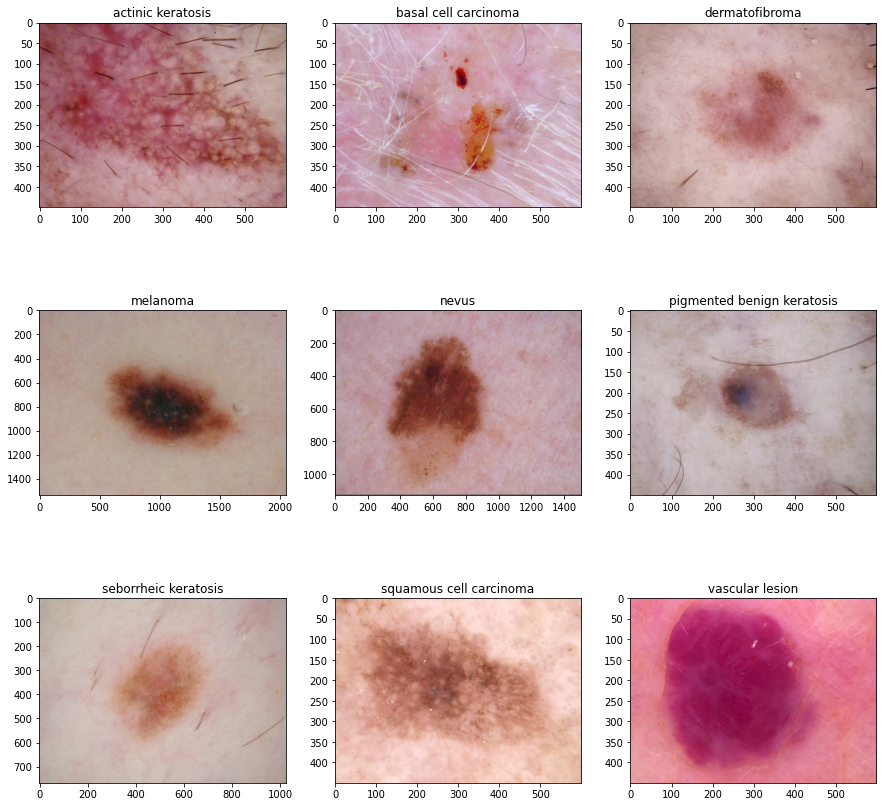

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3,3, i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from tensorflow.keras.regularizers import l2


In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))


model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128,activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(9,activation='softmax'))



In [ ]:
# summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 176, 176, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 88, 32)        0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 176, 176, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 88, 32)        0

### Train the model


In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 344s 6s/step - loss: 10.0973 - accuracy: 0.1858 - val_loss: 5.1783 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 318s 6s/step - loss: 4.5326 - accuracy: 0.2617 - val_loss: 4.1680 - val_accuracy: 0.2528
Epoch 3/20
56/56 [==============================] - 317s 6s/step - loss: 3.6501 - accuracy: 0.2790 - val_loss: 3.5397 - val_accuracy: 0.1588
Epoch 4/20
56/56 [==============================] - 317s 6s/step - loss: 3.0819 - accuracy: 0.2868 - val_loss: 3.1893 - val_accuracy: 0.1074
Epoch 5/20
56/56 [==============================] - 317s 6s/step - loss: 2.6652 - accuracy: 0.3181 - val_loss: 2.8233 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 318s 6s/step - loss: 2.4637 - accuracy: 0.3114 - val_loss: 2.6102 - val_accuracy: 0.2975
Epoch 7/20
56/56 [==============================] - 317s 6s/step - loss: 2.2755 - accuracy: 0.3538 - val_loss: 2.5544 - val_accuracy: 0.2617
Epoch 8/20
56/56 [=====

### Visualizing training results

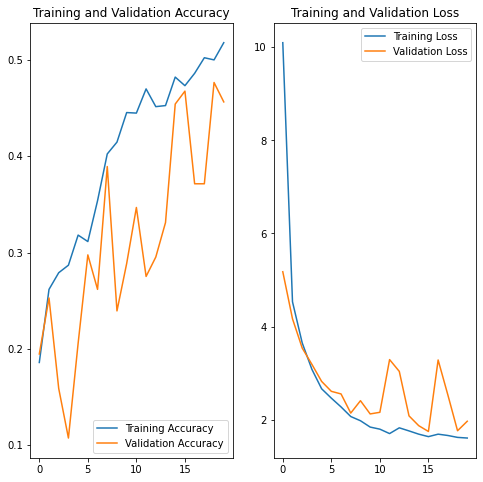

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Understandings from model fit

* Training Accuracy is 51% and validation accuracy is 45%
*  There is not much gap between accuracies so it is not overfitting.
*  As Model is not able to predict with accuracy and there is high error rate in both training and unseen data, it can be said model is underfit.
*  Model has become too simple and lack of enough data could also be the problem.
*  We can try Data Augmentation for improving accuracy.



#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


As it can be seen there is data imbalance with melanoma and pigmented are dominating.



*   seborrheic keratosis class has the least number of samples, 77.
*   melanoma(19%, 438 samples) and pigmented benign keratosis(21%, 468 samples) covers 40% of complete data together.



Let's try Data augmentation to fix this imbalance.

####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7A44465250>: 100%|██████████| 500/500 [00:24<00:00, 20.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A4600D750>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A462D1990>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7A46262110>: 100%|██████████| 500/500 [01:50<00:00,  4.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F7A464873D0>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A4670AA10>: 100%|██████████| 500/500 [00:22<00:00, 21.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7A462E2990>: 100%|██████████| 500/500 [00:51<00:00,  9.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A463129D0>: 100%|██████████| 500/500 [00:22<00:00, 22.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7A465DA6D0>: 100%|██████████| 500/500 [00:22<00:00, 22.46 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
len(path_list)

4500

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
len(lesion_list_new)

4500

In [ ]:
train_path = "/content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Train"
test_path = "/content/gdrive/MyDrive/Melanoma-Detection/SkincancerISIC/Test"

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [ ]:
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path +'/' +i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} = {length_tot} samples.')

actinic keratosis = 500 samples.
basal cell carcinoma = 500 samples.
dermatofibroma = 500 samples.
melanoma = 500 samples.
nevus = 500 samples.
pigmented benign keratosis = 500 samples.
seborrheic keratosis = 500 samples.
squamous cell carcinoma = 500 samples.
vascular lesion = 500 samples.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))


model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128,activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(9,activation='softmax'))

In [ ]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 176, 176, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 88, 88, 32)       

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 2900s 8s/step - loss: 5.4174 - accuracy: 0.1397 - val_loss: 3.4509 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 999s 6s/step - loss: 2.9213 - accuracy: 0.1543 - val_loss: 2.6152 - val_accuracy: 0.1411
Epoch 3/20
169/169 [==============================] - 990s 6s/step - loss: 2.4565 - accuracy: 0.1567 - val_loss: 2.3650 - val_accuracy: 0.1195
Epoch 4/20
169/169 [==============================] - 991s 6s/step - loss: 2.2490 - accuracy: 0.1849 - val_loss: 2.2724 - val_accuracy: 0.1485
Epoch 5/20
169/169 [==============================] - 986s 6s/step - loss: 2.1688 - accuracy: 0.1908 - val_loss: 2.3148 - val_accuracy: 0.1411
Epoch 6/20
169/169 [==============================] - 987s 6s/step - loss: 2.1099 - accuracy: 0.2023 - val_loss: 2.0287 - val_accuracy: 0.2294
Epoch 7/20
169/169 [==============================] - 992s 6s/step - loss: 2.0382 - accuracy: 0.2170 - val_loss: 2.0007 - val_accuracy: 0.2138
Epoch 8/2

## Observations

#### -- Lot many parameters made the model complex.
#### -- Training Accuracy:22% , Validation Accuracy:27%
#### -- 


Let's try reducing the filters and dropout.



In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))


model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(9,activation='softmax'))

In [ ]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
169/169 [==============================] - ETA: 0s - loss: 2.0068 - accuracy: 0.2290

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 387s 2s/step - loss: 2.0068 - accuracy: 0.2290 - val_loss: 1.7403 - val_accuracy: 0.3497
Epoch 2/10
169/169 [==============================] - 382s 2s/step - loss: 1.5911 - accuracy: 0.3811 - val_loss: 1.6667 - val_accuracy: 0.3719
Epoch 3/10
169/169 [==============================] - 381s 2s/step - loss: 1.5161 - accuracy: 0.4230 - val_loss: 1.3912 - val_accuracy: 0.4677
Epoch 4/10
169/169 [==============================] - 382s 2s/step - loss: 1.4176 - accuracy: 0.4642 - val_loss: 1.4840 - val_accuracy: 0.4298
Epoch 5/10
169/169 [==============================] - 382s 2s/step - loss: 1.3328 - accuracy: 0.4961 - val_loss: 1.2605 - val_accuracy: 0.5293
Epoch 6/10
169/169 [==============================] - 382s 2s/step - loss: 1.1964 - accuracy: 0.5471 - val_loss: 1.0946 - val_accuracy: 0.5835
Epoch 7/10
169/169 [==============================] - 382s 2s/step - loss: 1.1026 - accuracy: 0.5909 - val_loss: 1.1361 - val_accuracy: 0.5464
Epoch 8/10

## Visualisation

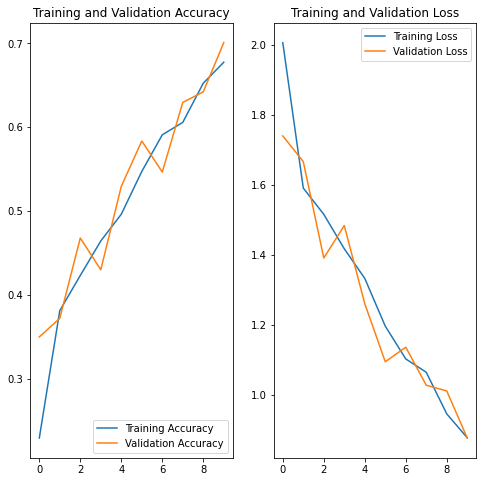

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Model Prediction


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

Actual Class basal cell carcinoma
Predictive Class actinic keratosis


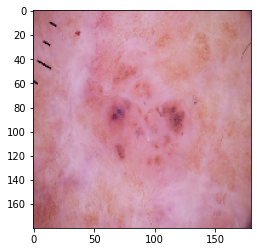

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

# Findings

#### - Training Accuracy : 68% Validation Accuracy: 70%
#### - Accuracy has improved.
#### - As above plot/ graph shows Training Accuracy and Validation Accuracy are very much together.
#### -  Underfit Solved.

Github link - https://github.com/srikanthsuryawanshi/Melanoma-Detection